# Digital Forensics Project: Generative Adversarial Network
## Generative Adversarial Network on FashionMNIST and DeepFashion Datasets
### Marchiori Francesco, ID: 2020389
### [Fashion MNIST Dataset](https://www.kaggle.com/zalando-research/fashionmnist)

## Importing the libraries

Other than the basic libraries needed in Python, Tensorflow is used (with Keras as its backend) in order to implement the GAN.

In [1]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
from IPython import display
import numpy as np

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

## Importing the Dataset

The [Fashion MNIST Dataset](https://www.kaggle.com/zalando-research/fashionmnist) is imported. It can be done by importing images or a .csv file, but since the `fashion_mnist.load_data()` loads the same dataset in a more convenient way, this way will be used. After that, the images are reshaped and normalized for the processing, resulting in 60000 images with resolution 28x28 with one channel (since they're not RGB) and pixel value between -1 and 1.

In [2]:
(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# String array for printing the labels
labels = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalization of the images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') # Size normalization
x_train = (x_train - 127.5) / 127.5  # Value normalization (in order to have values in [-1, 1])

print('Number of images in the training set:', len(x_train))

Number of images in the training set: 60000


### Dataset Plots

Some examples are generated in order to show what the dataset looks like.

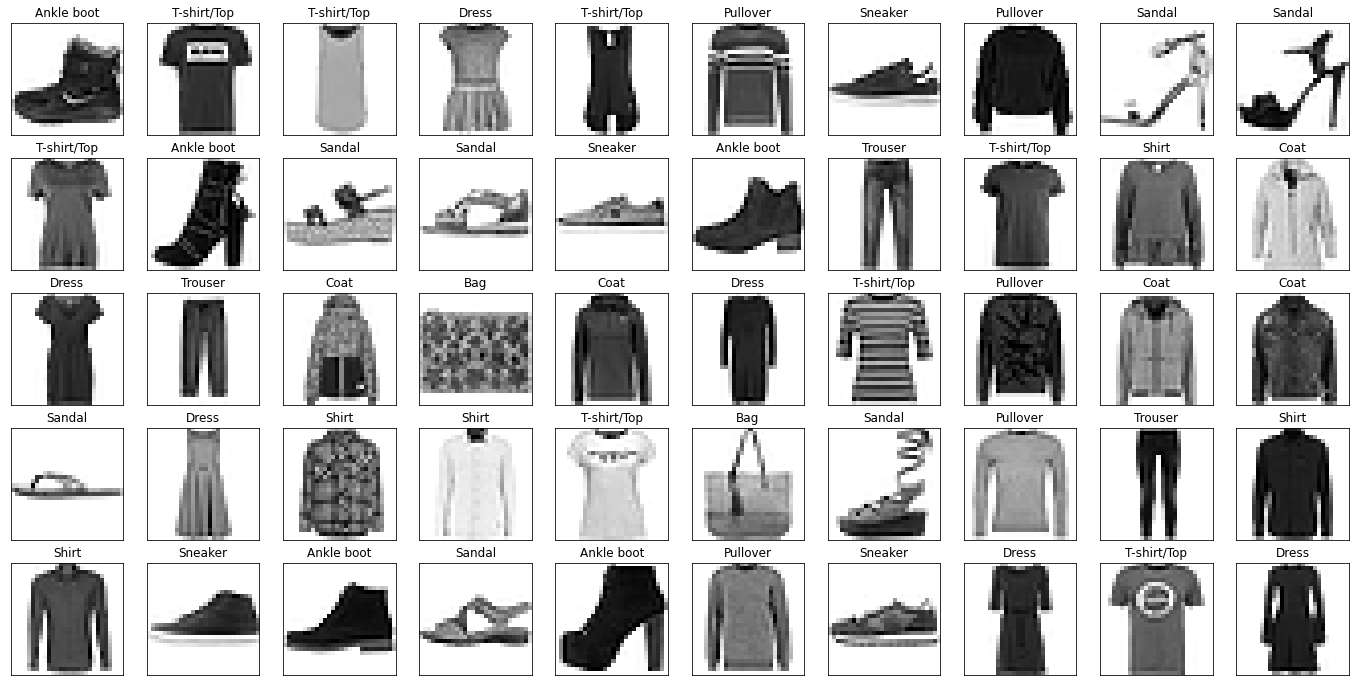

In [3]:
plt.figure(figsize=(24, 12))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(labels[y_train[i]])
    plt.imshow(x_train[i], cmap=plt.cm.binary)

plt.show()

### Creation of the dataset

Starting from *x_train*, a dataset with batches of size 256 is created.

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print('Dividing a buffer of size', BUFFER_SIZE, 'in batches of size', BATCH_SIZE, '\nNumber of batches in the dataset:', len(dataset))

Dividing a buffer of size 60000 in batches of size 256 
Number of batches in the dataset: 235


## GAN Model

In the following section the definitions of the generator and discriminator of the model are presented. Since the dataset is composed by images, the prevalent layer type will be the Convolutional Layer which makes these models Convolutional Neural Network, machine learning models particularly suited for the processing of images. Furthermore, instead of just adding layers and units mindlessly, in order to avoid overfitting the model has been kept as simple as possible without losing any generalization properties, having also the advantage of "fast" training times and lighter workload on the machine.

### Generator Model

The generator takes in input some random noise and returns in output a 28x28 image (with pixel value $\in [-1, 1]$ as the images in the dataset). This is done through a initial `Dense` layers which represent the standard fully connected layer in a neural network, followed by a cascade of `Conv2DTranspose` layers which implement the upsampling (from 7x7 to 28x28) with a `Leaky ReLU` activation for each of them (with respect to the standard ReLU activation function, the Leaky ReLU is differentiable also for values lower than 0). However in the output the activation function used is the `Tanh` because it takes in input an $x \in \mathcal{R}$ and outputs a value $y \in [-1, 1]$, therefore being consistent with the values of the images in the dataset.

In [5]:
def generator_model():
	"""
	Defines the generator model for the GAN using TensorFlow layers.
	
	INPUT: random noise
	OUTPUT: 28x28 image with pixel value between -1 and 1
	"""

	model = tf.keras.Sequential(name='Generator')

	# From input to a 7x7 image
	model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,), name='Dense'))
	model.add(layers.LeakyReLU(name='Leaky_ReLU_1'))
	model.add(layers.Reshape((7, 7, 128), name='Reshape'))

	# Upsampling (7x7 --> 14x14)
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_1'))
	model.add(layers.LeakyReLU(name='Leaky_ReLU_2'))

	# Upsampling (14x14 --> 28x28)
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_2'))
	model.add(layers.LeakyReLU(name='Leaky_ReLU_3'))

	# Generation the output
	model.add(layers.Conv2D(1, (7, 7), activation='tanh', padding='same', name='Conv2D'))
	return model

In [6]:
# Create the generator model and prints a summary of its layers

generator = generator_model()
generator.build()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense (Dense)                (None, 6272)              627200    
_________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)     (None, 6272)              0         
_________________________________________________________________
Reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
Conv2DT_1 (Conv2DTranspose)  (None, 14, 14, 128)       409728    
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 14, 14, 128)       0         
_________________________________________________________________
Conv2DT_2 (Conv2DTranspose)  (None, 28, 28, 128)       409728    
_________________________________________________________________
Leaky_ReLU_3 (LeakyReLU)     (None, 28, 28, 128)       0 

### Noise plots

Some examples are now generated by creating 16 instances of noise and, by taking them as input in the generator model, the output images are plotted.

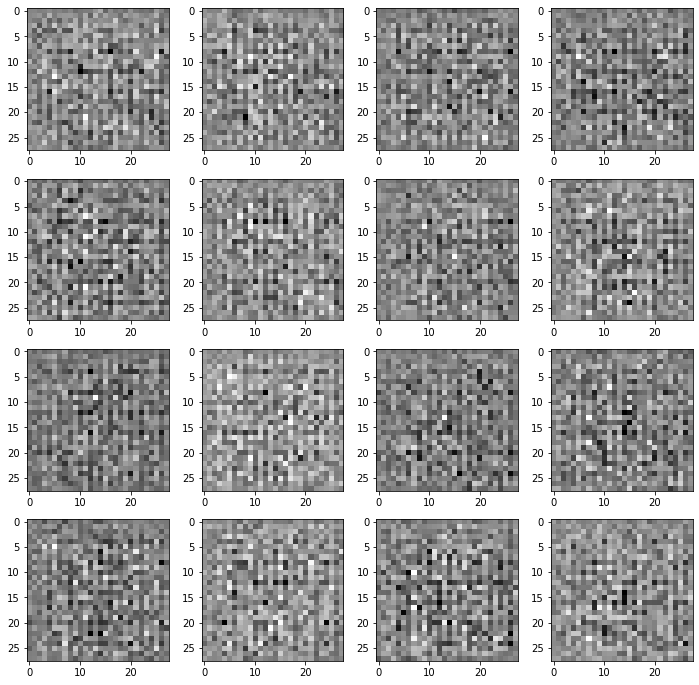

In [7]:
noise = tf.random.normal([16, 100])
generated_image = generator(noise, training=False)

plt.figure(figsize=(12, 12))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_image[i], cmap=plt.cm.binary)

## Discriminator Model

The discriminator takes in input an image of size 28x28 (with pixel value $\in [-1, 1]$ as the images in the dataset) and returns in output a value between 0 and 1. This output represent the prediction of the discriminator of the image taken in input, where 0 means that the image is fake and 1 means that the image is real. As the generator, it makes use of convolutional layers which this time are used for downsampling. The `Leaky ReLU` activation function is still used except for the last layer which is a `Flatten` layer follwed by `Dropout` (a technique used in machine learning in which some weight values are dropped in order to prevent overfitting) and a `Dense` layer which uses a `sigmoid` activation function because it takes in input an $x \in \mathcal{R}$ and outputs a value $y \in [0, 1]$, therefore being consistent with the output values expected by the discriminator.

In [8]:
def discriminator_model():
	"""
	Defines the discriminator model for the GAN using TensorFlow layers.
	
	INPUT: 28x28 image with pixel value between -1 and 1
	OUTPUT: value between 0 and 1 (0 = fake image, 1 = real image)
	"""

	model = tf.keras.Sequential(name='Discriminator')

	# Downsampling (28x28 --> 14x14)
	model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1], name='Conv2D_1'))
	model.add(layers.LeakyReLU(name='Leaky_ReLU_1'))

	# Downsampling (14x14 --> 7x7)
	model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2'))
	model.add(layers.LeakyReLU(name='Leaky_ReLU_2'))

	# Generation the output
	model.add(layers.Flatten(name='Flatten'))
	model.add(layers.Dropout(0.3, name='Dropout'))
	model.add(layers.Dense(1, activation='sigmoid', name='Sigmoid'))
	
	return model

In [9]:
discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 14, 14, 128)       3328      
_________________________________________________________________
Leaky_ReLU_1 (LeakyReLU)     (None, 14, 14, 128)       0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 7, 7, 128)         409728    
_________________________________________________________________
Leaky_ReLU_2 (LeakyReLU)     (None, 7, 7, 128)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
Sigmoid (Dense)              (None, 1)               

## Loss and Optimization

In order to train the model, it's now important to define its loss and its optimizers

In [10]:
# Setting the cross entropy

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def generator_loss(fake_output):
    """ Function for the calculation of the generator loss """

    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
def discriminator_loss(real_output, fake_output):
    """ Function for the calculation of the discriminator loss """

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [13]:
# Setting up the optimizers for the models

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [14]:
# Arrays for the losses

g_loss = []
d_loss = []

## Training

It's now time to train the model. However, to do so it's necessary to define the number of epochs, the noise dimension and thoroughly define the training procedure.

In [15]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
@tf.function
def train_step(images):
    """ Function for the definition of a train step """

    # Generate the noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Generate the images from the noise with the generator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      # Give in input to the discriminator both the real and the fake images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # Compute the losses for generator and discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply learned gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def generate_and_save_images(model, epoch, test_input):
  """ Function for the generation and saving the images """

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
      plt.axis('off')

  plt.savefig('./Images/Epoch_{:04d}.png'.format(epoch))
  plt.show()

In [18]:
def train(dataset, epochs):
  """ Defines all the actions that are done during training """

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    # Save losses of the epoch
    g_loss.append(gen_loss.numpy())
    d_loss.append(disc_loss.numpy())

    # Clear output
    display.clear_output(wait=True)

    # Print losses
    print('Generator loss: {}\nDiscriminator loss: {}'.format(gen_loss.numpy(), disc_loss.numpy()))

    # Produce images
    generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)

  generate_and_save_images(generator, epochs, seed)

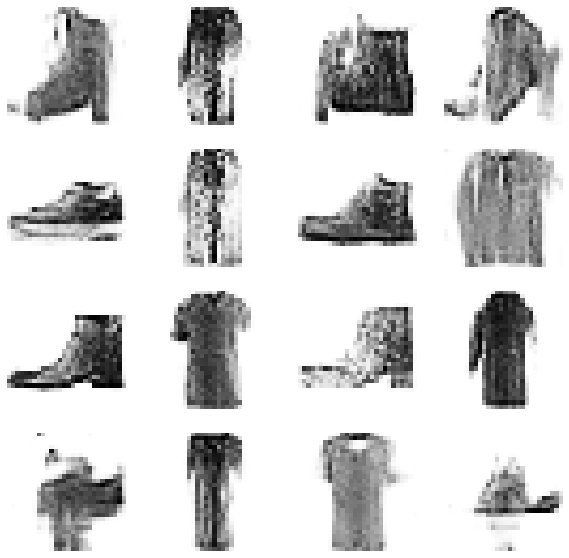

In [19]:
train(dataset, EPOCHS)

## Losses Plots

Generate the plot of the losses for both the generator and the discriminator.

In [20]:
def plot_losses(losses, title):
    """ Plots the losses given in input """

    epochs = len(losses)

    plt.figure(figsize=(20, 10))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.plot(losses)
    plt.savefig('./Losses/' + title + '_GAN.png', bbox_inches='tight')
    plt.show()

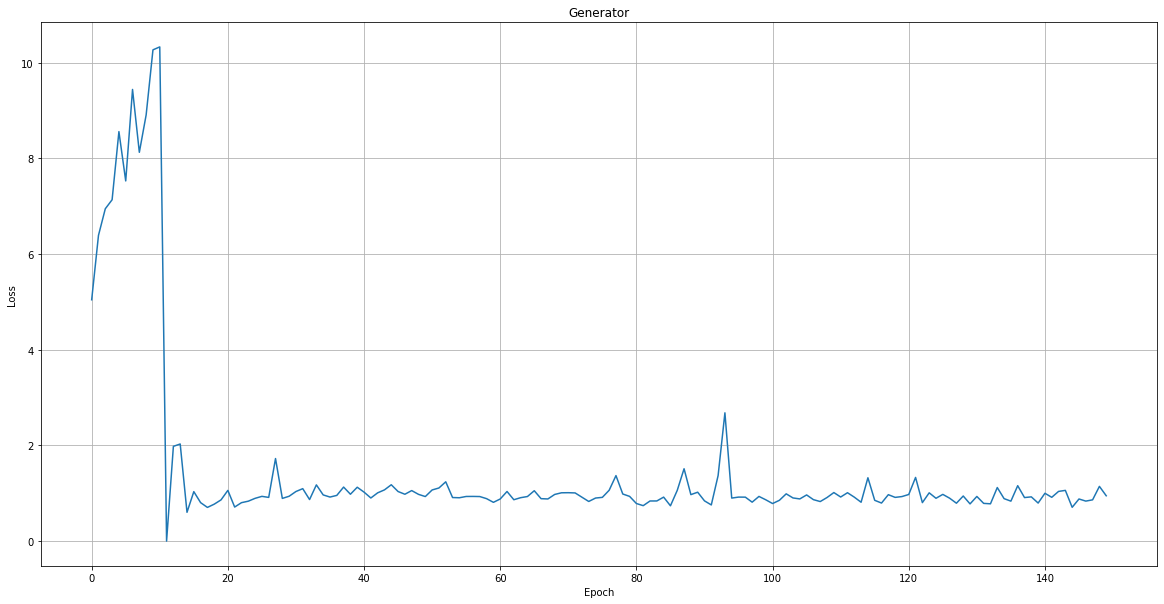

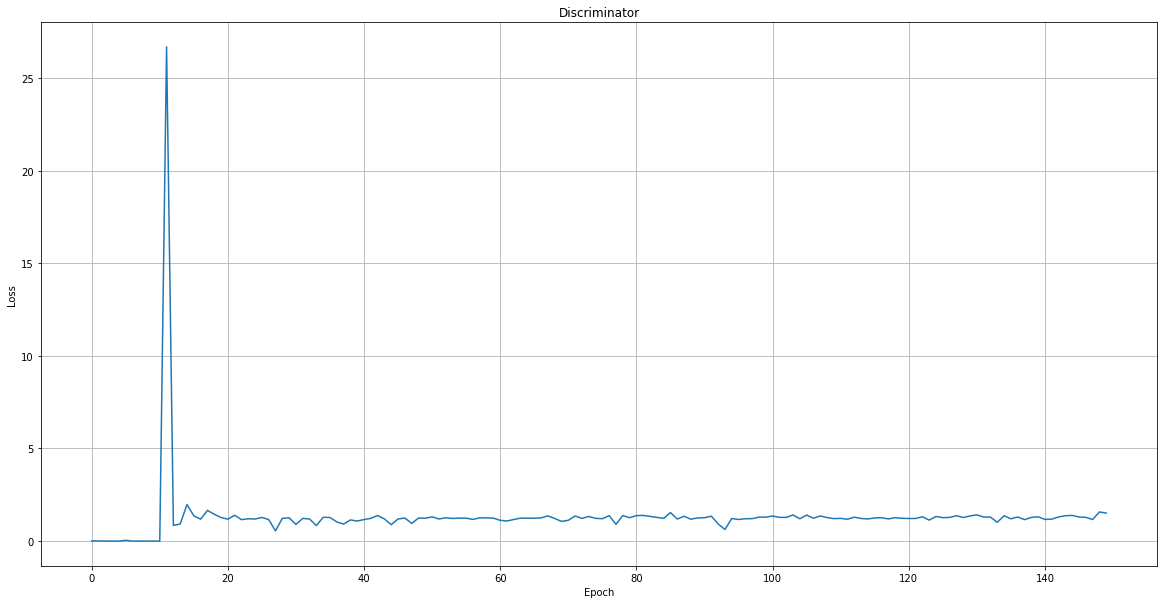

In [21]:
plot_losses(g_loss, 'Generator')
plot_losses(d_loss, 'Discriminator')